In [1]:
import numpy as np
from app.data_gen.sampling import sample_maturities, sample_moneyness

import app.training.networks as net
from app.training.dataset import IVS_DataModule, DualInput_IVS_DataModule

from app.recalibration.recalibration import *

In [2]:
nn1 = net.NN1Residual.load_from_checkpoint("models\\nn1\\version_33\\checkpoints\\best_model-epoch=141-val_loss=0.00.ckpt")
nn2 = net.NN3.load_from_checkpoint("models\\nn3\\version_3\\checkpoints\\best_model-epoch=22-val_loss=0.00.ckpt", nn1=net.NN1Residual(), nn2=net.NN2()).nn2

In [3]:
dataSet_NN1 = IVS_DataModule()
dataSet_NN2 = DualInput_IVS_DataModule()
dataSet_NN1.prepare_data()
dataSet_NN2.prepare_data()
scaler_nn1 = dataSet_NN1.min_max_scaler
scaler_nn2 = dataSet_NN2.scaler1

In [4]:
spot_price = 100.83

tau_grid = sample_maturities(10)
moneyness_grid = sample_moneyness(13)
jump_means = np.array([0.087]*5)
jump_variances = np.array([0.249]*5)

params = {'r': 0.0068,
          'q': 0.0161,
          'v0': 0.1046,
          'kappa': 5.421,
          'theta': 0.370,
          'sigma': 0.224,
          'rho': 0.242,
          'lambda_p': 0.289}

params.update({f"tau_{i}": tau for i, tau in enumerate(tau_grid, start=1)})
params.update({f"m_{i}": m for i, m in enumerate(moneyness_grid, start=1)})
params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means, start=1)})
params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances, start=1)})


data_point, generation_params = simulate_ivs_analyticaly(params=params, moneyness_grid=moneyness_grid, tau_grid=tau_grid, spot_price=spot_price, jump_means=jump_means, jump_variances=jump_variances)
ivs = np.array(data_point['implied_vol_surface']).reshape((1,-1))

In [5]:
X_new, V_new = simulate_single_step_bates(params=generation_params)

Time grid: [0.0, 0.019178082191780823]
Updated asset price at t = 0.019178082191780823: 104.87104741150135
Updated variance at t = 0.019178082191780823: 0.12579814653459245


In [6]:
IVS = simulate_ivs_with_neural_network(parameters=params, model=nn1, new_V=None, scaler=scaler_nn1)

In [7]:
new_params = update_parameters(parameters=params)

In [8]:
raw_jump_parameters = extract_jump_parameters_with_neural_networks(new_params=new_params, IVS_new=IVS.cpu().detach().numpy(), model=nn2, scaler=scaler_nn2)
# jump_means_new, jump_variances_new = extract_jump_parameters_with_neural_networks(new_params=new_params, IVS_new=ivs, model=nn2, scaler=scaler_nn2)

In [10]:
temp_params = deepcopy(params)
temp_params.update({f"nu_{i}": nu for i, nu in enumerate(raw_jump_parameters[: 5].cpu().detach().numpy(), start=1)})
temp_params.update({f"delta_{i}": delta for i, delta in enumerate(raw_jump_parameters[5: ].cpu().detach().numpy(), start=1)})
raw_features = np.array(list(temp_params.values())).reshape((1, -1))
norm_features = scaler_nn1.inverse_transform(raw_features)[0, -10:]
jump_means_new, jump_variances_new = norm_features[0: 5], norm_features[5:10]

In [11]:
# new_params.update({f"nu_{i}": nu for i, nu in enumerate([np.mean(jump_means_new)]*5, start=1)})
# new_params.update({f"delta_{i}": delta for i, delta in enumerate([np.mean(jump_variances_new)]*5, start=1)})
new_params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means_new, start=1)})
new_params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances_new, start=1)})

In [12]:
IVS_new = simulate_ivs_with_neural_network(parameters=new_params, model=nn1, new_V=None, scaler=scaler_nn1)

({'xlim': (np.float64(-0.06732305936073059), np.float64(1.2919805936073059)), 'autoscalex_on': True, 'ylim': (np.float64(0.7708333333333334), np.float64(1.2291666666666667)), 'autoscaley_on': True, 'zlim': (np.float64(0.3331320906678836), np.float64(0.6637410496671995)), 'autoscalez_on': True}, (30, -60, 0))


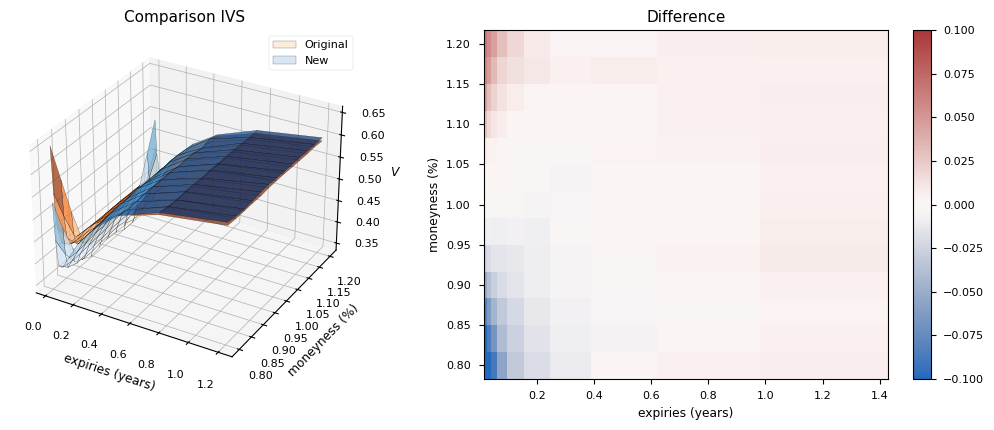

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import matplotlib.colors as colors

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import typing


# Plot the surface
# iv_matrix_analytic = np.array(data_point["implied_vol_surface"]).reshape(len(tau_grid), len(moneyness_grid))
iv_matrix_analytic = IVS.cpu().detach().numpy()[0].reshape(len(tau_grid), len(moneyness_grid))
iv_matrix_nn = IVS_new.cpu().detach().numpy()[0].reshape(len(tau_grid), len(moneyness_grid))

X, Y = np.meshgrid(np.array(tau_grid) / 365.0, moneyness_grid)

Z_diff = iv_matrix_nn - iv_matrix_analytic
# Z_diff = np.abs(iv_matrix_nn - iv_matrix_analytic)/iv_matrix_analytic

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['grid.linewidth'] = 0.5  # try a value like 0.1 instead of 0.01
plt.rcParams['axes.titlesize'] = 11
fig = plt.figure(figsize=figaspect(0.4))

# 3D Surface Plot
ax1: Axes3D = typing.cast(Axes3D, fig.add_subplot(121, projection='3d'))
surf1 = ax1.plot_surface(X, Y, iv_matrix_analytic.T, cmap='Oranges', alpha=0.7, edgecolor='k', linewidth=0.2, antialiased=True)
surf2 = ax1.plot_surface(X, Y, iv_matrix_nn.T, cmap='Blues', alpha=0.7, edgecolor='k', linewidth=0.2, antialiased=True)
ax1.set_xlabel("expiries (years)")
ax1.set_ylabel("moneyness (%)")
# ax1.set_zlim(0.15, 0.58)
ax1.set_zlabel("$V$")
ax1.set_title("Comparison IVS")
ax1.legend(["Original", "New"], framealpha=1)
print(ax1._get_view())

# Heatmap
ax2 = fig.add_subplot(122)
norm = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
im  = ax2.pcolormesh(
    X, Y, Z_diff.T,
    # cmap='crest',  # A perceptually uniform colormap ideal for continuous data
    cmap='vlag',  # A perceptually uniform colormap ideal for continuous data
    shading='auto', 
    norm=norm
)
cbar_diff = fig.colorbar(im, ax=ax2)
ax2.set_xlabel("expiries (years)")
ax2.set_ylabel("moneyness (%)")
ax2.set_title("Difference")
# ax2.set_title("Percentage Error [%]")

plt.tight_layout()
# plt.savefig("rec_case3.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
scaler_nn1.inverse_transform(jump_means_new)

tensor([0.2964, 0.2889, 0.2413, 0.0199, 0.0388], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
np.mean(jump_variances_new)

tensor(0.2524, device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
new_params

{'r': 0.0068,
 'q': 0.0161,
 'v0': 0.1046,
 'kappa': 5.421,
 'theta': np.float64(0.3666824376030504),
 'sigma': np.float64(0.21856767478177638),
 'rho': np.float64(0.9980355833455078),
 'lambda_p': 0.289,
 'tau_1': np.uint16(7),
 'tau_2': np.uint16(11),
 'tau_3': np.uint16(17),
 'tau_4': np.uint16(27),
 'tau_5': np.uint16(44),
 'tau_6': np.uint16(69),
 'tau_7': np.uint16(110),
 'tau_8': np.uint16(175),
 'tau_9': np.uint16(277),
 'tau_10': np.uint16(440),
 'm_1': np.float64(0.8),
 'm_2': np.float64(0.8333333333333334),
 'm_3': np.float64(0.8666666666666667),
 'm_4': np.float64(0.9),
 'm_5': np.float64(0.9333333333333333),
 'm_6': np.float64(0.9666666666666667),
 'm_7': np.float64(1.0),
 'm_8': np.float64(1.0333333333333332),
 'm_9': np.float64(1.0666666666666667),
 'm_10': np.float64(1.1),
 'm_11': np.float64(1.1333333333333333),
 'm_12': np.float64(1.1666666666666665),
 'm_13': np.float64(1.2),
 'nu_1': tensor(0.1183),
 'nu_2': tensor(0.1183),
 'nu_3': tensor(0.1183),
 'nu_4': tensor(0